# Stock Price prediction using regression

In [60]:
import pandas as pd
import quandl
import math, datetime
import numpy as np
from sklearn import preprocessing,model_selection, svm
from sklearn.linear_model import LinearRegression
import pickle
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

In [46]:
quandl.ApiConfig.api_key = "1aciUNo5qGvdG2_Z5d4J"
df = quandl.get("WIKI/GOOGL")

In [47]:
print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

Since, the prices like Adj. Open, Adj. High, etc. themselves don't tell directly about volatility, etc., create new features which tell about the percentage difference.

In [48]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Volume']]

In [49]:
print(df.head())

            Adj. Close    HL_PCT  PCT_change      Volume
Date                                                    
2004-08-19   50.322842  8.441017    0.324968  44659000.0
2004-08-20   54.322689  8.537313    7.227007  22834300.0
2004-08-23   54.869377  4.062357   -1.227880  18256100.0
2004-08-24   52.597363  7.753210   -5.726357  15247300.0
2004-08-25   53.164113  3.966115    1.183658   9188600.0


In [50]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)

forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True)


In [51]:
print(df.head())

            Adj. Close    HL_PCT  PCT_change      Volume      label
Date                                                               
2004-08-19   50.322842  8.441017    0.324968  44659000.0  69.078238
2004-08-20   54.322689  8.537313    7.227007  22834300.0  67.839414
2004-08-23   54.869377  4.062357   -1.227880  18256100.0  68.912727
2004-08-24   52.597363  7.753210   -5.726357  15247300.0  70.668146
2004-08-25   53.164113  3.966115    1.183658   9188600.0  71.219849


In [52]:
X = np.array(df.drop(labels=['label'], axis=1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])
y_lately = y[-forecast_out:]
y = y[:-forecast_out]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)


## Using Linear Regression

In [53]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)

### Pickling
Serializing the model object in order to re-train it with any new data in the future.

In [61]:
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(model, f)

pickle_in = open('linearregression.pickle', 'rb')
model = pickle.load(pickle_in)

In [54]:
print(accuracy)

0.9756055935180622


Forecasting

In [55]:
forecast_set = model.predict(X_lately)
print(forecast_set, forecast_out)

[1084.68720629 1099.04325975 1112.69310073 1107.60812334 1101.24139018
 1098.82406528 1097.19292636 1093.64366437 1087.88652239 1083.43386326
 1081.24690804 1099.97117789 1118.72868564 1124.14708721 1138.7746021
 1143.05834619 1141.51326909 1138.95254551 1140.75544893 1158.59806341
 1158.86653193 1167.95532737 1164.76055549 1172.75793675 1192.83958668
 1206.04562028 1200.53937808 1212.11838487 1217.08632828 1216.48372302
 1207.15186387 1212.08205621 1210.90438319 1146.37644281 1092.42013083] 35


Plotting

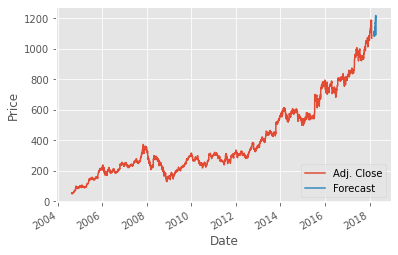

In [58]:
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Using Support-vector regression

In [56]:
model = svm.SVR()
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(accuracy)

0.8165203346622719
